In [1]:
!pip install cvxopt

In [0]:
import numpy as np


class Kernel(object):
    """Check kernels here https://en.wikipedia.org/wiki/Support_vector_machine"""
    @staticmethod
    def linear():
        return lambda x, y: np.inner(x, y)

    @staticmethod
    def gaussian(sigma):
        return lambda x, y: np.exp(-(np.linalg.norm(x-y)**2/(sigma**2)))
    
import numpy as np
import cvxopt.solvers
import logging


MIN_SUPPORT_VECTOR_MULTIPLIER = 1e-5


class SVMTrainer(object):
    def __init__(self, kernel, c=0.1):
        self._kernel = kernel
        self._c = c


    def train(self, X, y):
        lagrange_multipliers = self._compute_lagrange_multipliers(X, y)
        return self._create_predictor(X, y, lagrange_multipliers)


    def _kernel_matrix(self, X):
        n_samples = X.shape[0]
        K = np.zeros((n_samples, n_samples))
        for i, x_i in enumerate(X):
            for j, x_j in enumerate(X):
                K[i, j] = self._kernel(x_i, x_j)
        return K


    def _create_predictor(self, X, y, lagrange_multipliers):
        support_vector_indices = lagrange_multipliers > MIN_SUPPORT_VECTOR_MULTIPLIER
        support_multipliers = lagrange_multipliers[support_vector_indices]
        support_vectors = X[support_vector_indices]
        support_vector_labels = y[support_vector_indices]
        bias = np.mean(
            [y_k - SVMPredictor(
                    kernel=self._kernel,
                    bias=0.0,
                    weights=support_multipliers,
                    support_vectors=support_vectors,
                    support_vector_labels=support_vector_labels
                ).predict(x_k) for (y_k, x_k) in zip(support_vector_labels, support_vectors)
            ]
        )
        return SVMPredictor(
            kernel=self._kernel,
            bias=0.0,
            weights=support_multipliers,
            support_vectors=support_vectors,
            support_vector_labels=support_vector_labels
        )

    def _compute_lagrange_multipliers(self, X, y):
        n_samples = X.shape[0]
        K = self._kernel_matrix(X)
        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(-1 * np.ones(n_samples))
        G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        h = cvxopt.matrix(np.zeros(n_samples))
        A = cvxopt.matrix(y, (1, n_samples))
        b = cvxopt.matrix(0.0)

        # Check this

        # -a_i \leq 0
        # G_std = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        # h_std = cvxopt.matrix(np.zeros(n_samples))

        # # a_i \leq c
        # G_slack = cvxopt.matrix(np.diag(np.ones(n_samples)))
        # h_slack = cvxopt.matrix(np.ones(n_samples) * self._c)

        # G = cvxopt.matrix(np.vstack((G_std, G_slack)))
        # h = cvxopt.matrix(np.vstack((h_std, h_slack)))
        
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        return np.ravel(solution['x'])


class SVMPredictor(object):
    def __init__(
                self,
                kernel,
                bias,
                weights,
                support_vectors,
                support_vector_labels
            ):
        
        self._kernel = kernel
        self._bias = bias
        self._weights = weights
        self._support_vectors = support_vectors
        self._support_vector_labels = support_vector_labels


        assert len(support_vectors) == len(support_vector_labels)
        assert len(weights) == len(support_vector_labels)


        logging.info("Bias: %s", self._bias)
        logging.info("Weights: %s", self._weights)
        logging.info("Support vectors: %s", self._support_vectors)
        logging.info("Support vector labels: %s", self._support_vector_labels)

    def predict(self, x):
        result = self._bias
        for w_i, x_i, y_i in zip(self._weights,
                                 self._support_vectors,
                                 self._support_vector_labels):
            result += w_i * y_i * self._kernel(x_i, x)

        return np.sign(result).item()

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools

def plot(predictor, X, y, grid_size):
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_size),
        np.linspace(y_min, y_max, grid_size),
        indexing='ij'
    )
    
    flatten = lambda m: np.array(m).reshape(-1,)

    result = []
    
    for (i, j) in itertools.product(range(grid_size), range(grid_size)):
        point = np.array([xx[i, j], yy[i, j]]).reshape(1, 2)
        result.append(predictor.predict(point))

    Z = np.array(result).reshape(xx.shape)
    
    plt.contourf(
        xx, yy, Z,
        cmap=cm.Paired,
        levels=[-0.01, 0.01],
        extend='both',
        alpha=0.8
    )
    
    
    plt.scatter(
        flatten(X[:, 0]),
        flatten(X[:, 1]),
        c=flatten(y),
        cmap=cm.Paired
    )
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

In [0]:
num_samples=100
num_features=2
grid_size=200
samples = np.matrix(np.random.normal(size=num_samples * num_features)
                        .reshape(num_samples, num_features))
labels = 2 * (samples.sum(axis=1) > 0) - 1.0

     pcost       dcost       gap    pres   dres
 0: -9.4197e+00 -2.6289e+01  1e+02  8e+00  2e+00
 1: -1.6251e+01 -3.1287e+01  4e+01  3e+00  7e-01
 2: -2.7505e+01 -3.9842e+01  3e+01  1e+00  4e-01
 3: -3.1858e+01 -3.5567e+01  6e+00  3e-01  8e-02
 4: -3.2840e+01 -3.3676e+01  9e-01  1e-02  3e-03
 5: -3.3346e+01 -3.3393e+01  5e-02  4e-04  1e-04
 6: -3.3380e+01 -3.3382e+01  2e-03  1e-05  3e-06
 7: -3.3381e+01 -3.3381e+01  8e-05  2e-07  4e-08
 8: -3.3381e+01 -3.3381e+01  2e-06  2e-09  4e-10
Optimal solution found.


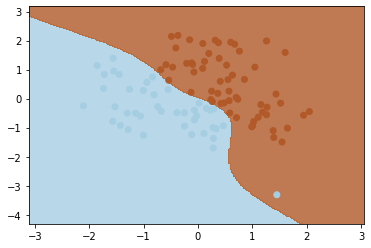

In [66]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
trainer = SVMTrainer(Kernel.gaussian(1))
X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size=.5,
                                                    random_state=0)
predictor = trainer.train(X_train, y_train)
plot(predictor, samples, labels, grid_size)

In [0]:
fpr = dict()
tpr = dict()
roc_auc = dict()
y_score = [predictor.predict(x) for x in X_test]
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:], y_score[:])
    roc_auc[i] = auc(fpr[i], tpr[i])

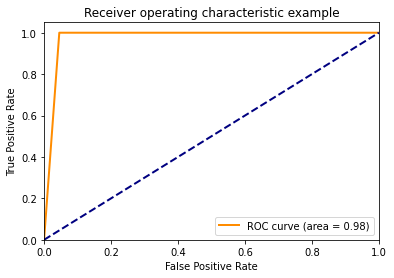

In [68]:
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


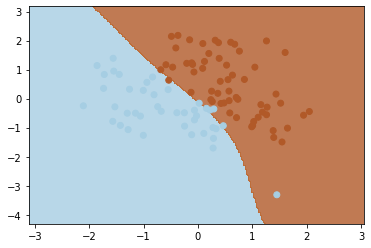

In [78]:
from sklearn.svm import SVC
clf = SVC(kernel = "sigmoid", probability=True)
clf.fit(X_train, y_train)
plot(clf, samples, labels, grid_size)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split


from scipy import interp
from sklearn.metrics import roc_auc_score

In [81]:
y_score = clf.predict(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
print(y_score)
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

[ 1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1. -1.  1.  1. -1.
 -1. -1.  1.  1.  1. -1. -1. -1. -1.  1.  1.  1.  1.  1. -1. -1. -1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1.  1.  1.  1.  1.  1.]


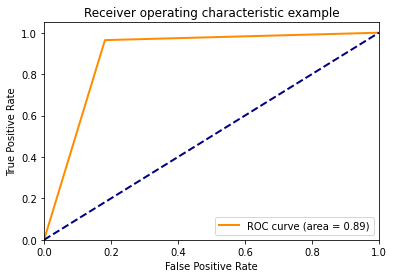

In [82]:
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()